This notebook transforms the labelled side and bottom camera DLC datasets to a merged dataset

In [356]:
(metadata_row['Trial'],frame_name)

('trial_00091__2022-04-20_15-47-48', 'img0000.png')

In [357]:
merge_im_name

'/home/jupyter/bucket/Data/Behavior_videos/DLC_models/BCI_side&bottom_2022/labeled-data/BCI26_trial_00091__2022-04-20_15-47-48/img0000.png'

In [354]:
np.where(csv_bottom[('bodyparts', 'coords')] == 'labeled-data/{}/{}'.format(metadata_row['Trial'],frame_name))[0]

array([], dtype=int64)

In [6]:
side_dir_name_after_merge

'/home/jupyter/bucket/Data/Behavior_videos/DLC_models/BCI_side&bottom_side_only_2023_Sept/labeled-data/BCI26_trial_00037__2022-04-10_10-56-46'

trial_00037__2022-04-10_10-56-46 already done
trial_00029__2022-04-10_10-55-08 already done
trial_00034__2022-04-10_10-56-05 already done
trial_00040__2022-04-10_10-57-18 already done
trial_00050__2022-04-10_10-59-06 already done
trial_00054__2022-04-10_10-59-59 already done
trial_00070__2022-04-10_11-02-50 already done
trial_00028__2022-04-15_14-44-06 already done
trial_00031__2022-04-15_14-44-37 already done
trial_00077__2022-04-15_14-53-23 already done
trial_00097__2022-04-15_14-57-10 already done
trial_00064__2022-04-20_15-43-58 already done
trial_00067__2022-04-20_15-44-29 already done
trial_00089__2022-04-20_15-47-34 already done
trial_00096__2022-04-20_15-48-27 already done
trial_00001__2022-04-20_15-34-56 already done
trial_00012__2022-04-20_15-36-30 already done
trial_00013__2022-04-21_13-10-15 already done
trial_00057__2022-04-21_13-18-18 already done
trial_00088__2022-04-21_13-23-34 already done
trial_00003__2022-04-22_12-09-51 already done
trial_00007__2022-04-22_12-10-39 a

ffmpeg version 4.1.11-0+deb10u1 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 8 (Debian 8.3.0-6)
  configuration: --prefix=/usr --extra-version=0+deb10u1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --e

trial_00125__2022-04-22_12-36-00 already done
trial_00120__2022-04-22_12-34-49 already done
trial_00100__2022-04-22_12-29-55 already done
trial_00111__2022-04-22_12-32-24 already done


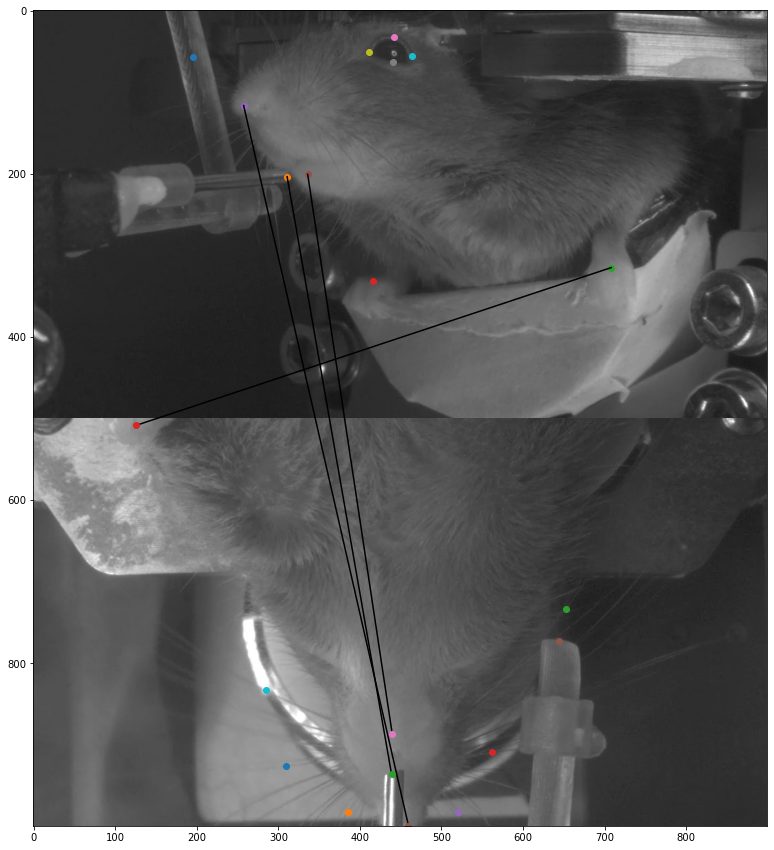

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import png # pip install pypng
from PIL import Image
from pathlib import Path
import numpy as np
import json
import shutil

base_bottom = '/home/jupyter/bucket/Data/Behavior_videos/DLC_models/BCI_bottom_2022_10_06'
base_side = '/home/jupyter/bucket/Data/Behavior_videos/DLC_models/BCI_side_2022_08_12'
metadata_file = '/home/jupyter/bucket/Data/Behavior_videos/DLC_models/Metadata_BCI_DLC_labels.csv'

base_merge = '/home/jupyter/bucket/Data/Behavior_videos/DLC_models/BCI_side&bottom_2023_Sept'
base_side_after_merging = '/home/jupyter/bucket/Data/Behavior_videos/DLC_models/BCI_side&bottom_side_only_2023_Sept'
base_bottom_after_merging = '/home/jupyter/bucket/Data/Behavior_videos/DLC_models/BCI_side&bottom_bottom_only_2023_Sept'

metadata = pd.read_csv(metadata_file)
swap_paws_on_side_camera = True # paws were mislabelled on side camera, fix it here
plot_fiducials = True
overwrite = False
#flip_side_view = True
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)



if plot_fiducials == True:
    fig = plt.figure(figsize = [15,15])
    ax  = fig.add_subplot(1,1,1)
for metadata_row in metadata.iterrows():
    metadata_row = metadata_row[1]
    merge_dir_name = os.path.join(os.path.join(base_merge,'labeled-data',metadata_row['Mouse']+'_'+metadata_row['Trial']))
    merge_dir_plot_name = os.path.join(os.path.join(base_merge,'labeled-data-plots',metadata_row['Mouse']+'_'+metadata_row['Trial']))
    merge_video_name = os.path.join(os.path.join(base_merge,'videos',metadata_row['Mouse']+'_'+metadata_row['Trial']+'.mp4'))
    bottom_video_name = os.path.join(os.path.join(base_bottom,'videos',metadata_row['Mouse']+'_'+metadata_row['Trial']+'.mp4'))
    side_video_name = os.path.join(os.path.join(base_side,'videos',metadata_row['Mouse']+'_'+metadata_row['Trial']+'.mp4'))
    
    side_dir_name_after_merge = os.path.join(os.path.join(base_side_after_merging,'labeled-data',metadata_row['Mouse']+'_'+metadata_row['Trial']))
    bottom_dir_name_after_merge = os.path.join(os.path.join(base_bottom_after_merging,'labeled-data',metadata_row['Mouse']+'_'+metadata_row['Trial']))
    side_video_name_after_merge = os.path.join(os.path.join(base_side_after_merging,'videos',metadata_row['Mouse']+'_'+metadata_row['Trial']+'.mp4'))
    bottom_video_name_after_merge =os.path.join(os.path.join(base_bottom_after_merging,'videos',metadata_row['Mouse']+'_'+metadata_row['Trial']+'.mp4'))
    
    
    
    
    if os.path.exists(merge_video_name) and not overwrite:
        print('{} already done'.format(metadata_row['Trial']))
        continue
    
        
    
    
    
    if plot_fiducials:
        Path(merge_dir_plot_name).mkdir(parents=True, exist_ok=True)                       
    if not metadata_row['side view'] == metadata_row['bottom view'] == 'x': 
        continue 
    print('starting {}'.format(metadata_row['Trial']))
    frames_side = os.listdir(os.path.join(base_side,'labeled-data',metadata_row['Trial']))
    for frame_name in frames_side:
        if '.csv' in frame_name:
            csv_side = pd.read_csv(os.path.join(base_side,'labeled-data',metadata_row['Trial'],frame_name),header=[1,2])
            
            if swap_paws_on_side_camera:
                pawlx = csv_side[('PawL','x')].copy()
                pawly = csv_side[('PawL','y')].copy()
                pawrx = csv_side[('PawR','x')].copy()
                pawry = csv_side[('PawR','y')].copy()
                csv_side[('PawL','x')] = pawrx
                csv_side[('PawL','y')] = pawry
                csv_side[('PawR','x')] = pawlx
                csv_side[('PawR','y')] = pawly
            break
    frames_bottom = os.listdir(os.path.join(base_bottom,'labeled-data',metadata_row['Trial']))
    csv_out_name = None
    for frame_name in frames_bottom:
        if '.csv' in frame_name:
            csv_bottom = pd.read_csv(os.path.join(base_bottom,'labeled-data',metadata_row['Trial'],frame_name),header=[1,2])
            csv_out_name = frame_name
            break
    side_body_parts = []
    bottom_body_parts = []
    matched_side = []
    matched_bottom = []
    for side_body_part in csv_side.keys():
        if side_body_part[1] not in ['x']:
            continue
        side_body_parts.append(side_body_part[0])
        for bottom_body_part in csv_bottom.keys():
            if bottom_body_part[1] not in ['x']:
                continue
            if bottom_body_part[0].lower() == side_body_part[0].lower() and side_body_part[0].lower() != 'pole':
                bottom_body_parts.append(bottom_body_part[0])
                matched_side.append(len(side_body_parts)-1)
                matched_bottom.append(len(bottom_body_parts)-1)
    for bottom_body_part in csv_bottom.keys():
        if bottom_body_part[1] not in ['x']:
            continue
        if bottom_body_part[0] not in bottom_body_parts:
            bottom_body_parts.append(bottom_body_part[0])
    
    cols_new = []
    cols_new_bottom = []
    cols_new_side = []
    out_csv_dict = {'file':[]}
    out_csv_dict_side = {'file':[]}
    out_csv_dict_bottom = {'file':[]}
    for side_body_part in side_body_parts:
        cols_new.append((side_body_part+'_side','x'))
        cols_new.append((side_body_part+'_side','y'))
        cols_new_side.append((side_body_part+'_side','x'))
        cols_new_side.append((side_body_part+'_side','y'))
        out_csv_dict[side_body_part+'_side'] = {'x':[],
                                                'y':[]}
        out_csv_dict_side[side_body_part+'_side'] = {'x':[],
                                                     'y':[]}

    for bottom_body_part in bottom_body_parts:
        cols_new.append((bottom_body_part+'_bottom','x'))
        cols_new.append((bottom_body_part+'_bottom','y'))
        cols_new_bottom.append((bottom_body_part+'_bottom','x'))
        cols_new_bottom.append((bottom_body_part+'_bottom','y'))
        out_csv_dict[bottom_body_part+'_bottom'] = {'x':[],
                                                    'y':[]}
        out_csv_dict_bottom[bottom_body_part+'_bottom'] = {'x':[],
                                                           'y':[]}
        
    for frame_name in frames_side:

        if '.png' not in frame_name:
            continue
        try:
            bottom_im_name = os.path.join(base_bottom,'labeled-data',metadata_row['Trial'],frame_name)
            bottom_im_name_after_merge = os.path.join(bottom_dir_name_after_merge,frame_name)
            im_bottom = Image.open(bottom_im_name)
            side_im_name = os.path.join(base_side,'labeled-data',metadata_row['Trial'],frame_name)
            side_im_name_after_merge = os.path.join(side_dir_name_after_merge,frame_name)
            im_side = Image.open(side_im_name)
        except:
            print('could not open {}.. skipping'.format(frame_name))
            
            continue
        im_merge  =np.concatenate([im_side,im_bottom],0)
        im_merge= Image.fromarray(im_merge)
        
        merge_im_name = os.path.join(merge_dir_name,frame_name)

        
        try:
            try:
                bottom_csv_idx = np.where(csv_bottom[('bodyparts', 'coords')] == 'labeled-data/{}/{}'.format(metadata_row['Trial'],frame_name))[0][0]
            except:
                bottom_csv_idx = np.where(csv_bottom[('Unnamed: 2_level_0', 'Unnamed: 2_level_1')] == frame_name)[0][0]
            try:
                side_csv_idx = np.where(csv_side[('bodyparts', 'coords')] == 'labeled-data/{}/{}'.format(metadata_row['Trial'],frame_name))[0][0]
            except:
                side_csv_idx = np.where(csv_side[('Unnamed: 2_level_0', 'Unnamed: 2_level_1')] == frame_name)[0][0]
        except:
            print('could not find correct index in csv file, skipping {}'.format(frame_name))
            continue
        if plot_fiducials:
            ax.clear()
            ax.imshow(im_merge)
        
        
        Path(merge_dir_name).mkdir(parents=True, exist_ok=True)         
        Path(os.path.join(base_merge,'videos')).mkdir(parents=True, exist_ok=True)         
        Path(side_dir_name_after_merge).mkdir(parents=True, exist_ok=True)         
        Path(os.path.join(base_side_after_merging,'videos')).mkdir(parents=True, exist_ok=True)         
        Path(bottom_dir_name_after_merge).mkdir(parents=True, exist_ok=True)         
        Path(os.path.join(base_bottom_after_merging,'videos')).mkdir(parents=True, exist_ok=True)   
        
        
        im_merge.save(merge_im_name,"PNG")
        
        shutil.copyfile(bottom_im_name, bottom_im_name_after_merge)
        shutil.copyfile(side_im_name, side_im_name_after_merge)

        for side_i,side_body_part in enumerate(side_body_parts):
            x = csv_side[(side_body_part,'x')][side_csv_idx]
            y = csv_side[(side_body_part,'y')][side_csv_idx]
            out_csv_dict_side[side_body_part+'_side']['x'].append(x)
            out_csv_dict_side[side_body_part+'_side']['y'].append(y)
            
            out_csv_dict[side_body_part+'_side']['x'].append(x)
            out_csv_dict[side_body_part+'_side']['y'].append(y)
            if plot_fiducials:
                
                ax.plot(x,y,'o')
                if side_i in matched_side:
                    bottom_i = np.asarray(matched_bottom)[np.asarray(matched_side) == side_i][0]
                    bottom_body_part = np.asarray(bottom_body_parts)[bottom_i]
                    xx = csv_bottom[(bottom_body_part,'x')][bottom_csv_idx]
                    yy = csv_bottom[(bottom_body_part,'y')][bottom_csv_idx]
                    yy+=500
                    ax.plot([x,xx],[y,yy],'k-')
                
        for bottom_i,bottom_body_part in enumerate(bottom_body_parts):
            x = csv_bottom[(bottom_body_part,'x')][bottom_csv_idx]
            y = csv_bottom[(bottom_body_part,'y')][bottom_csv_idx]
            out_csv_dict_bottom[bottom_body_part+'_bottom']['x'].append(x)
            out_csv_dict_bottom[bottom_body_part+'_bottom']['y'].append(y)
            y+=500 # the Y dimension of the movie is HARD-CODED here
            if plot_fiducials:
                ax.plot(x,y,'o')
            out_csv_dict[bottom_body_part+'_bottom']['x'].append(x)
            out_csv_dict[bottom_body_part+'_bottom']['y'].append(y)
            # out_csv_dict[(bottom_body_part+'_bottom','x')].append(x)
            # out_csv_dict[(bottom_body_part+'_bottom','y')].append(y)
            # out_csv_dict[side_body_part+'_bottom'] = {}
            # out_csv_dict[side_body_part+'_bottom']['x'] = x
            # out_csv_dict[side_body_part+'_bottom']['y'] = y
       # out_csv_dict['file'] = merge_im_name[len(base_merge)+1:]
        if plot_fiducials:
            fig.savefig(os.path.join(merge_dir_plot_name,frame_name))
            
        out_csv_dict['file'].append(merge_im_name[len(base_merge)+1:])
        out_csv_dict_side['file'].append(merge_im_name[len(base_merge)+1:])
        out_csv_dict_bottom['file'].append(merge_im_name[len(base_merge)+1:])
        
    df_out = pd.DataFrame(0, index=out_csv_dict['file'], columns=cols_new)#dlc_data.columns)
    df_out.columns = pd.MultiIndex.from_tuples(df_out.columns)
    for col in cols_new:
        df_out[col] = out_csv_dict[col[0]][col[1]]
    df_out.to_csv(os.path.join(merge_dir_name,csv_out_name))
    
    #######
    df_out_side = pd.DataFrame(0, index=out_csv_dict_side['file'], columns=cols_new_side)#dlc_data.columns)
    df_out_side.columns = pd.MultiIndex.from_tuples(df_out_side.columns)
    for col in cols_new_side:
        df_out_side[col] = out_csv_dict_side[col[0]][col[1]]
    df_out_side.to_csv(os.path.join(side_dir_name_after_merge,csv_out_name))
    
    df_out_bottom = pd.DataFrame(0, index=out_csv_dict_bottom['file'], columns=cols_new_bottom)#dlc_data.columns)
    df_out_bottom.columns = pd.MultiIndex.from_tuples(df_out_bottom.columns)
    for col in cols_new_bottom:
        df_out_bottom[col] = out_csv_dict_bottom[col[0]][col[1]]
    df_out_bottom.to_csv(os.path.join(bottom_dir_name_after_merge,csv_out_name))
    
    shutil.copyfile(side_video_name, side_video_name_after_merge)
    shutil.copyfile(bottom_video_name, bottom_video_name_after_merge)
    ###########
    metadata_out = {'matching_part_indices':[matched_side,list(np.asarray(matched_bottom)+len(side_body_parts))],
                    'matching_part_names':[list(np.asarray(list(out_csv_dict.keys()))[1:][np.asarray(matched_side)]),list(np.asarray(list(out_csv_dict.keys()))[1:][np.asarray(matched_bottom)+len(side_body_parts)])]}
    with open(os.path.join(merge_dir_name,'metadata.json'), "w") as outfile:
        json_object = json.dumps({'matching_part_indices':[matched_side,list(np.asarray(matched_bottom)+len(side_body_parts))],
                                 'matching_part_names':[list(np.asarray(list(out_csv_dict.keys()))[1:][np.asarray(matched_side)]),list(np.asarray(list(out_csv_dict.keys()))[1:][np.asarray(matched_bottom)+len(side_body_parts)])]}, 
                                 indent=4,
                                cls=NpEncoder)
        outfile.write(json_object)
    # with open(os.path.join(merge_dir_name,'metadata.json'), "w") as outfile:
    #     json.dump(metadata_out, outfile)
    
    try:
        os.system('ffmpeg -y -i "{}" -i "{}" -filter_complex vstack "{}"'.format(side_video_name,bottom_video_name,merge_video_name))
    except:
        pass
            
            
            
        

        